On my road trip, I kept track of (almost) all the money I spent. I was already fairly surprised with some of my [quick calculations](/2019/07/road-trip-stats) about how little I ended up spending (just around $4000!), and I also wanted to dive a bit more into how much I spent, where, and on what. So here we go!

In [238]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The data

I tracked all my expenses in a notebook throughout my trip, and then entered them into an Excel spreadsheet.

In [239]:
df = pd.read_excel('money.xlsx')
# Last column just has some notes, but no data
df = df.iloc[:, :5]
df.head()

,date,item,price,category,ben_or_claire
0,2019-02-17,gas,37.14,car,NaN
1,2019-02-17,sonic,4.90,food,NaN
2,2019-02-18,coffee,2.50,food,NaN
3,2019-02-18,lunch,12.00,food,NaN
4,2019-02-18,dinner tacos,8.15,food,NaN


I tracked the date, the expense, and the price. I also manually assigned each expense a "category." And, for the parts of the trip where Ben joined me, I also tracked who paid for the expense. Unfortunately, I didn't do a great job of tracking expenses during these weekends, so I probably won't be able to dig into that split.

Anyway, let's see how much I spent on each category:

In [240]:
(df.groupby('category')
    .sum()
    .sort_values(by='price', ascending=False)
    #.plot(kind='bar', rot=45)
)

,price
category,
car,1721.53
food,1235.75
gear,659.79
lodging,569.02
fun,382.89
dumb,134.01
postcards,83.06
misc,59.70
souvenirs,29.00


Let's look into a couple of the more dubious categories: "dumb" (this is when I locked myself out, I think), "gear" (which is missing all of my pre-trip REI purchases), "misc" (what does that even mean), and "souvenirs" (I think that was also only one purchase).

In [241]:
check_cats = ['dumb', 'gear', 'misc', 'souvenirs']
df.query('category == @check_cats').sort_values(by='category')

,date,item,price,category,ben_or_claire
22,2019-02-25,phone repair,69.01,dumb,NaN
203,2019-04-27,car lockout,65.00,dumb,NaN
21,2019-02-25,rei,1.60,gear,NaN
37,2019-02-26,knife,8.09,gear,NaN
77,2019-04-17,propane,9.36,gear,NaN
131,2019-05-01,home depot,11.66,gear,NaN
172,2019-05-19,propane,6.38,gear,NaN
188,2019-05-24,rei,124.33,gear,NaN
204,2019-02-14,rei,352.40,gear,NaN
205,2019-02-16,rei (parents paid),297.55,gear,NaN


Oh, right! Not only did I lock myself out of my car at the Grand Canyon, but I also broke my phone on the first part of my trip and had to fix it. Okay, we'll leave these two "dumb" expenses in.

The gear category is a bit tough: I exchanged my air mattress a few times, and was eventually reimbursed for it, which explains the "negative" expense on 5/28. Also, my parents got me a lot of gear for the combination of Christmas, graduation, and my birthday -- that's the 2/16 trip for about $300. We'll leave that in here, though, since that's money that I was going to spend on this trip regardless. 

Like I thought, there's only one souvenir expense (oops). I'll just lump that into the "misc" category.

In [242]:
# Replace "souvenir" category with "misc"
df['category'] = df['category'].replace('souvenirs', 'misc')

## The road trip expenses

Ok, now I'm ready to dive in. I'll first look only at the parts of the trip that I spent on my own, since when Ben was visiting we stayed in AirBnB's and went out a lot -- lots of fun, definitely a great way to spend time and money, but not the road trip I was planning or intending for. 

Let's look at how much I spent on each category during each part of the trip. I'll do a bit of pandas-fu to get the sum of all expenses in each category, one time for the whole dataset and one time just for the part where it was only me. 

_Coding notes: I [just learned](https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_r.html) that you can use the `.assign()` to make a new column within a chain of pandas commands, like the R version of `mutate`. Cool!_

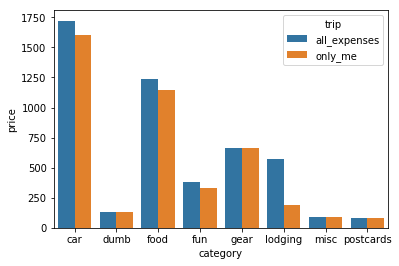

In [243]:
category_totals = pd.concat([
    df.groupby('category').sum().assign(trip='all_expenses').reset_index(),
    df[df['ben_or_claire'].isna()].groupby('category').sum().assign(trip='only_me').reset_index()
])

sns.barplot(data=category_totals, x='category', y='price', hue='trip')

Hm, it's pretty hard to tell how much I spent on the part of the trip with Ben. Let's directly calculate the difference...

In [244]:
# I think there's a way to use .diff() for this, but it's throwing bugs right now
wide_totals = category_totals.pivot(index='category', columns='trip', values='price')

wide_totals['all_expenses'] - wide_totals['only_me']

category
car          120.85
dumb           0.00
food          92.34
fun           50.00
gear           0.00
lodging      382.65
misc           0.00
postcards      0.00
dtype: float64

Hm. That's definitely not the whole picture. I'm pretty sure the food and fun expenses are way off -- but that makes sense, given that I didn't really keep track of everything I spent during those days, let alone what Ben was spending. Also those parts involved much more alcohol and spontaneous purchases sooo... 😅

I also don't fully remember how I entered the lodging bills -- sometimes I think I put down the full cost (like when I paid for our AirBnBs on the first part of the trip), but other times I only put down my part (especially when Ben paid). 

Anyway, no need to dive into this because I *know* I have incomplete data. Let's move on with analyzing just the road trip part where I was alone! That said, I'll keep any car expenses that I encountered during our joint trip, because I would have needed to pay those anyway. I'll remove any food we split because that's just too complicated...

In [245]:
df = df[ (df['category'] == "car") | (df['ben_or_claire'].isna()) ]

df['price'].sum()

4349.76

Ok, so after all this cleaning and manipulation the total amount I spent looks a little different than what I posted previously, but basically the same: on my ~3 month road trip, I spent about $4300!

I have a lot of questions that I could answer by combining this data with my other mileage and lodgind datasets, but for now let's see what other questions we can answer just from this data alone.

### Daily expenses

If we divide that by the total number of days I previously calculated being on this trip for, that gives us an estimate of the daily cost* of my cross-country road trip!

_\*Of course, that's recognizing that there's a couple of high-expense weekends missing in this average, which would have been replaced by camping or crashing with friends -- so the daily average for a pure road trip should be a little higher than this._

In [246]:
df.groupby('category').sum().sort_values(by='price', ascending=False) / 105

,price
category,
car,16.395524
food,10.889619
gear,6.283714
fun,3.170381
lodging,1.774952
dumb,1.276286
misc,0.844762
postcards,0.791048


Hah! Glad to see my mistakes only cost me a little over a dollar a day! 😆

Ok, but we all know that the average isn't necessarily that informative. Especially on this trip, I tended to spend a lot of money for a few days and then go to the wilderness for a few days and not spend anything at all. Let's see if this impression is correct. 

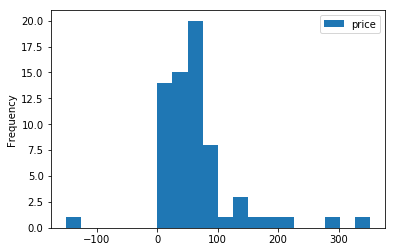

In [247]:
df.groupby('date').sum().plot(kind='hist', bins=20)

At first, this histogram surprised me because there seem to be so few days where I spent zero money. But actually, this data doesn't include those days! So this histogram just shows the money I spent, on days when I spent _some_ money.

How many days in a row would I spend money?

In [248]:
days_btw_purchases = df.sort_values(by='date')['date'].drop_duplicates().diff().dt.days
days_btw_purchases[days_btw_purchases < 30].value_counts()

1.0    55
2.0     8
3.0     2
Name: date, dtype: int64

So there were 55 days in a row where I made some sort of purchase, and only 2 days where I waited 3 days between purchases. I didn't ever wait more than 3 days (except the one-month break when I went to Malaysia, lol).

This is actually quite surprising! In my mind, I would go to the big city, buy a bunch of stuff, and then retreat to the wilderness. But now that I think about it, in actuality I would do that, but for big expenses only. I made small purchases almost every day, either stopping by a coffee shop or getting pie at Capitol Reef or other small joys.

Let's see how these numbers change as I increase the amount of money that I consider a purchase:

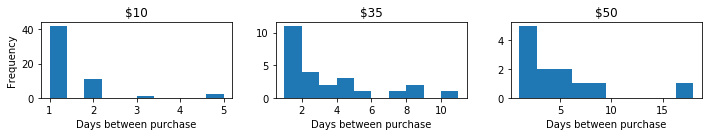

In [249]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2))

prices = [10, 35, 50]
i = 0
for p in prices:
    
    days_btw_purchases = df.query('price > @p').sort_values(by='date')['date'].drop_duplicates().diff().dt.days
    days_btw_purchases[days_btw_purchases < 30].plot(kind='hist', ax=ax[i])
    
    ax[i].set_title('${}'.format(p))
    if i == 0:
        ax[i].set_ylabel('Frequency')
    else:
        ax[i].set_ylabel('')

    ax[i].set_xlabel('Days between purchase')
    i += 1
fig.tight_layout()

Damn. There were five times when I spent more than \\$50 two days in a row?? And in general, there were only a few times when I went more than a week in between > \\$50 expenses. 

On the flip side of purchases, there was only one time when I went like 5 days without spending more than \\$10. This was probably the week that I was hanging out in Utah, from Bryce to Moab. 

The \\$35 price cutoff is intersting, because it kind of _de facto_ removes most of my gas fillups. Here the purchases are more varied: sometimes I spent more than \\$35 two days in a row, and other times I went about a week without spending that much on any given day. This jives much more with my feeling on how I spent money this trip.

### Gas, groceries, and camping

Okay, that's pretty interesting. But let's zoom in more specifically to the three big categories of expenses.

The "car" category includes gas and other things, but here I'm honestly only interested in looking at how often I paid for gas. 

In [250]:
df['sub_category'] = df['category']
df.loc[df['item'].str.contains('gas'), 'sub_category'] = 'gas'
df.loc[df['item'].str.contains('groceries'), 'sub_category'] = 'groceries'

In [253]:
df['days_since_last_same_category'] = df.sort_values(by='date').groupby('category')['date'].diff().dt.days
df['days_since_last_same_subcategory'] = df.sort_values(by='date').groupby('sub_category')['date'].diff().dt.days

# Remove the large gap from Malaysia
df.loc[df['days_since_last_same_category'] > 30, 'days_since_last_same_category'] = np.nan
df.loc[df['days_since_last_same_subcategory'] > 30, 'days_since_last_same_subcategory'] = np.nan

df.head(10)

,date,item,price,category,ben_or_claire,sub_category,days_since_last_same_category,days_since_last_same_subcategory
0,2019-02-17,gas,37.14,car,NaN,gas,NaN,NaN
1,2019-02-17,sonic,4.90,food,NaN,food,NaN,NaN
2,2019-02-18,coffee,2.50,food,NaN,food,1.0,1.0
3,2019-02-18,lunch,12.00,food,NaN,food,0.0,0.0
4,2019-02-18,dinner tacos,8.15,food,NaN,food,0.0,0.0
5,2019-02-18,gas,32.89,car,NaN,gas,1.0,1.0
6,2019-02-18,groceries,35.21,food,NaN,groceries,0.0,NaN
7,2019-02-19,gas,23.41,car,NaN,gas,1.0,1.0
8,2019-02-19,guitar center,68.17,fun,NaN,fun,NaN,NaN
9,2019-02-20,gas,8.66,car,NaN,gas,1.0,1.0


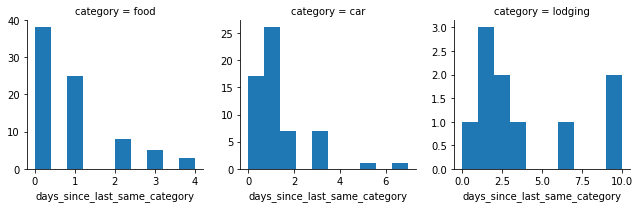

In [254]:
keep_cats = ['food', 'car', 'lodging']
g = sns.FacetGrid(data=df.query('category == @keep_cats'), col='category', 
                  sharey=False, col_order=keep_cats, sharex=False)
g.map(plt.hist, 'days_since_last_same_category')

Hm. This is also surprising, and tells me that I spent money on way more days than I thought. 

Specifically, I bought food two days in a row about 40 times. And then the majority of the rest of the times I bought food were just 1 day apart. In other words, for the majority of my trip I bought food either every day or every other day.

Looks like the story is pretty similar for car-related expenses: the majority of expenses had a lag of 0-2 days. So for the majority of my trip, I spent money on my car somewhere between every day and every 3 days. That makes sense -- I usually moved to a new spot every 2-3 days, which entailed a lot of driving, and I must have gotten gas basically every time I did that.

Now, lodging. Let's see: does this make sense? My impression is that I super rarely paid for housing... What this is saying is that yes, there were a few times when I went a week or more without paying for housing, but when I did pay for housing I paid for housing again within the next three days. I have a separate spreadsheet where I tracked the lodging expenses more cleanly, we'll have to come back to this when we analyze that one...

Let's zoom into the groceries and gas question, because I think these expenses are where I'm drawing my intuition from.

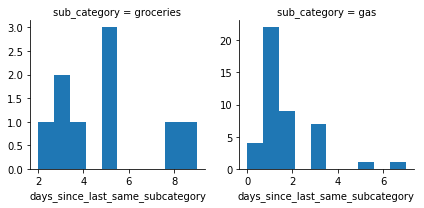

In [255]:
keep_subcats = ['groceries', 'gas']
g = sns.FacetGrid(data=df.query('sub_category == @keep_subcats'), col='sub_category', 
                  sharey=False, col_order=keep_subcats, sharex=False)
g.map(plt.hist, 'days_since_last_same_subcategory')

Yeah, I think this checkes out. Of the 9 times I bought groceries, about 2/3 of them were at least 5 days apart. That makes sense -- I feel like I tended to buy groceries about once a week, and sometimes I'd have forgotten something so would need to swing back by the store the next day to get a bit more.

Similarly, most of my gas purchases were something like 2-3 days apart. This also makes sense, given my reasoning above about how often I was on the move.

## Coffee

Okay, I'm getting a bit tired of this deep dive but there is one more thing I want to know: how much money did I spend on caffeine?

As I was putting these data into the spreadsheet, I found myself often typing "coffee" or "tea." Ruh roh...

In [261]:
# Get any items where I specified coffee or tea
df[df['item'].str.contains('coffee|tea')]['item'].value_counts()

coffee                  15
tea                      3
coffee and lunch         2
coffee and donuts        1
tea and gatorade         1
coffee and breakfast     1
coffee and muffin        1
pie and coffee           1
iced tea                 1
Name: item, dtype: int64

Hehe, can you tell that I liked to treat myself to coffee in a variety of ways? :)

Okay but back to business: how much did I spend, and how often?

In [262]:
caffeine = df[df['item'].str.contains('coffee|tea')]
caffeine['price'].sum()

136.11

Hah! I spent \\$136 on caffeine (plus, at times, also food -- but let's be real the breakfast was just an excuse to buy coffee).

Text(0.5,0,'Days between caffeine')

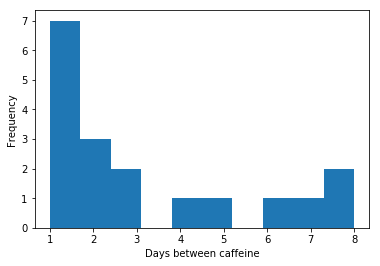

In [267]:
days_btw_caffeine = caffeine.sort_values(by='date')['date'].drop_duplicates().diff().dt.days
days_btw_caffeine = days_btw_caffeine[days_btw_caffeine < 30]
days_btw_caffeine.plot(kind='hist')
plt.xlabel('Days between caffeine')

And therein, my friends, lies the histogram of an addict: I rarely went more than 5 days in between buying myself some form of caffeine.

So it goes. 